<a href="https://colab.research.google.com/github/jolenele/Model-NPL-Object-Detection-Medical-Bills/blob/main/NPL_Object_Detection_Medical_Bills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS 663 - Computer Vision

## **Object Dection - Medical Bills**

## Step 1 - Setup environment

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

## 2. Prepare dataset

Using Google Drive, we mount Google Drive onto Google Colab.

Afterwards, we set the file paths to our dog vs cats dataset.

In [5]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [6]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [7]:
# setup the directory names
base_dir = "/content/drive/MyDrive/Colab Notebooks/datasets/invoices"
image_dir= base_dir

train_dir= base_dir + "/train"
trainAnnotations_dir= base_dir + "/train/labels"

In [8]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow import keras
from PIL import Image

Next, we loop through all the images and look for the bounding boxes.

*   List item
*   List item



In [9]:
# Path to images and annotations
path_images = train_dir + "/images"
path_annot = trainAnnotations_dir + "/"

image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# # loop over the annotations and images, preprocess them and store in lists
# for i in range(len(annot_paths)):
#     tree = ET.parse(os.path.join(path_annot, annot_paths[i]))
#     root = tree.getroot()

#     # Check for bounding box
#     bbox = root.find(".//bndbox")
#     if bbox is None:
#         print(f"No bounding box found in {annot_paths[i]}, skipping...")
#         continue
#     else:
#       print("bounding box found")
#     # Extract bounding box coordinates
#     top_left_x = int(bbox.find("xmin").text)
#     top_left_y = int(bbox.find("ymin").text)
#     bottom_right_x = int(bbox.find("xmax").text)
#     bottom_right_y = int(bbox.find("ymax").text)

#     # Load, resize image, and process bounding box
#     image = keras.utils.load_img(os.path.join(path_images, image_paths[i]))
#     (w, h) = image.size
#     image = image.resize((image_size, image_size))
#     images.append(keras.utils.img_to_array(image))

#     targets.append(
#         (
#             top_left_x / w,
#             top_left_y / h,
#             bottom_right_x / w,
#             bottom_right_y / h,
#         )
#     )

# # Convert the list to numpy array, split to train and test dataset
# (x_train), (y_train) = (
#     np.asarray(images[: int(len(images) * 0.8)]),
#     np.asarray(targets[: int(len(targets) * 0.8)]),
# )
# (x_test), (y_test) = (
#     np.asarray(images[int(len(images) * 0.8) :]),
#     np.asarray(targets[int(len(targets) * 0.8) :]),
# )

In [10]:

for i in range(0, len(annot_paths)- 1000):
    # Access bounding box coordinates
    annot = np.loadtxt(path_annot + annot_paths[i])
    if annot.ndim == 1:
        annot = annot.reshape(1, -1)

    # Load the corresponding image
    image = keras.utils.load_img(path_images + "/" + image_paths[i])
    (w, h) = image.size[:2]

    # Resize image and append to list
    image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))

    # Process each bounding box in the annotation
    for box in annot:
        class_id, center_x, center_y, width, height = box

        # Convert YOLO format (center x, center y, width, height) to absolute coordinates
        top_left_x = (center_x - width / 2) * w
        top_left_y = (center_y - height / 2) * h
        bottom_right_x = (center_x + width / 2) * w
        bottom_right_y = (center_y + height / 2) * h

        # Append scaled bounding box coordinates to targets list
        targets.append(
            (
                top_left_x / w,
                top_left_y / h,
                bottom_right_x / w,
                bottom_right_y / h,
            )
        )
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

## 3. Implement multilayer-perceptron (MLP)

Creating the function for implementing Multilayer Perceptron.

We implement a dropout_rate to reduce overfitting of the model.

In [11]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## 4. Implement the patch creation layer

In [12]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


## 4.b Display patches for an input image

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


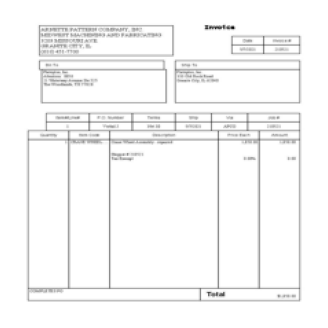

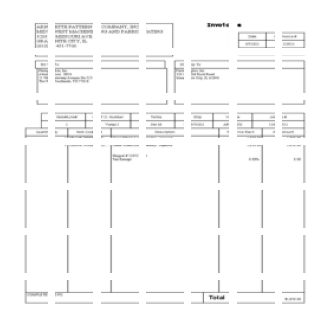

In [13]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

## 5. Implement the patch encoding layer

The `PatchEncoder` layer linearly transforms a patch by projecting it into a
vector of size `projection_dim`. It also adds a learnable position
embedding to the projected vector.

The patch encoding is used to produce latent embeddings (linear projection and positional embedding).

In [14]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded


## 6. Build the ViT model

The ViT model has multiple Transformer blocks.
The `MultiHeadAttention` layer is used for self-attention,
applied to the sequence of image patches. The encoded patches (skip connection)
and self-attention layer outputs are normalized and fed into a
multilayer perceptron (MLP).
The model outputs four dimensions representing
the bounding box coordinates of an object.

In [15]:

def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


## 6. Compile, fit and train the model


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 1.2252 - val_loss: 0.3148
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.6840 - val_loss: 0.2533
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.3452 - val_loss: 0.2426
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.2674 - val_loss: 0.2308
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2290 - val_loss: 0.2188
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.2357 - val_loss: 0.2073
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.1936 - val_loss: 0.1962
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1897 - val_loss: 0.1855
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2297 - val_loss: 0.1752
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.1768 - val_loss: 0.1654
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1501 - val_loss: 0.1562
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.1643 - val_loss: 0.1472
Epoch 13

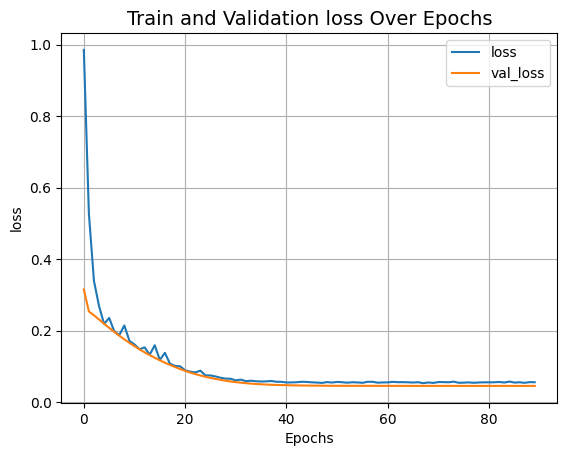

In [16]:

def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_object_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")


## Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<ipython-input-17-63c1f31d4d4e>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
mean_iou: 0.03244959291405484


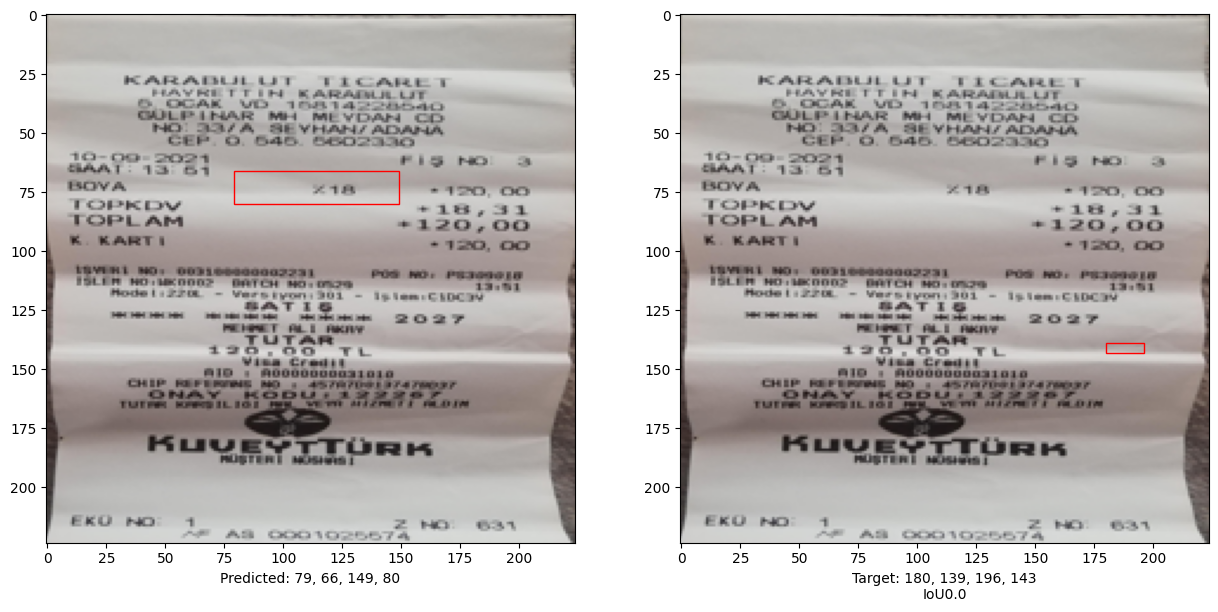

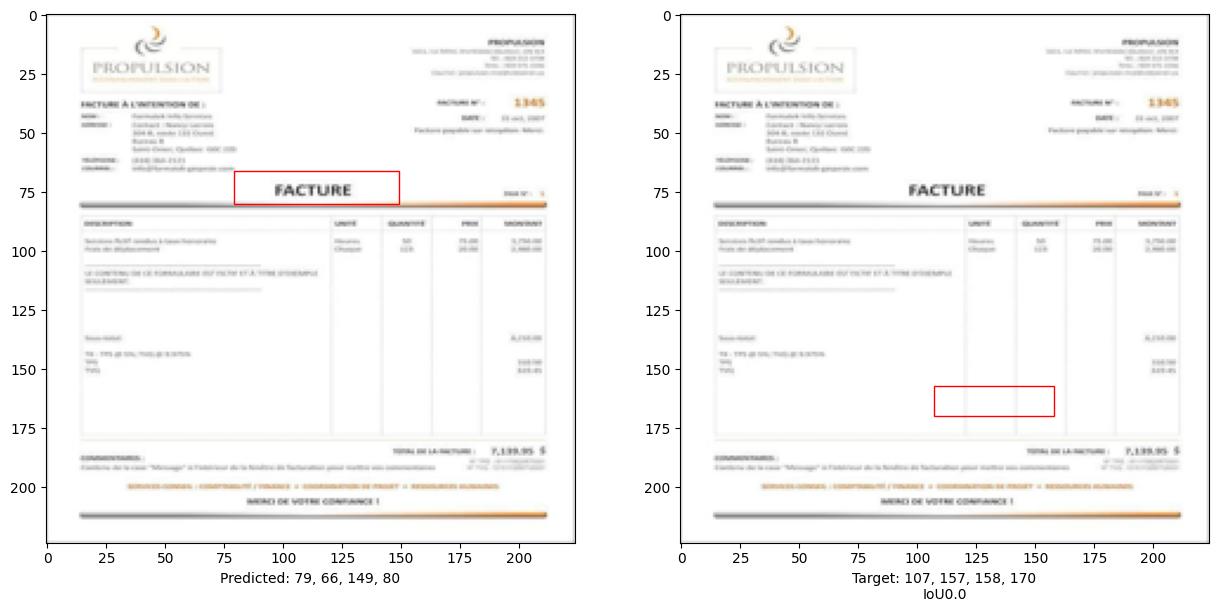

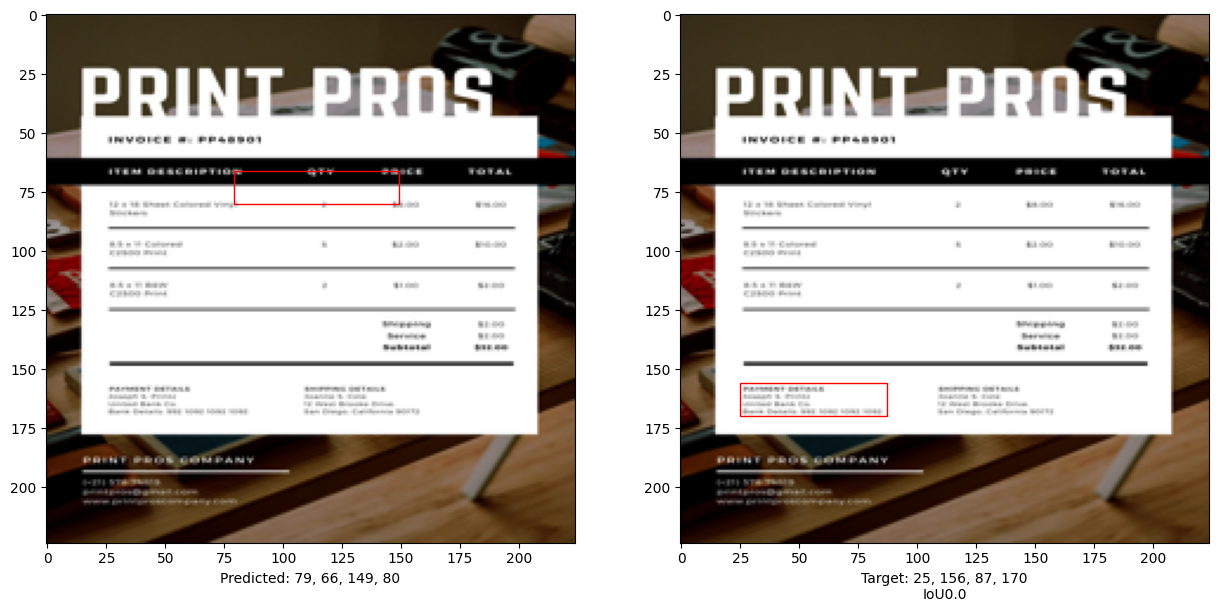

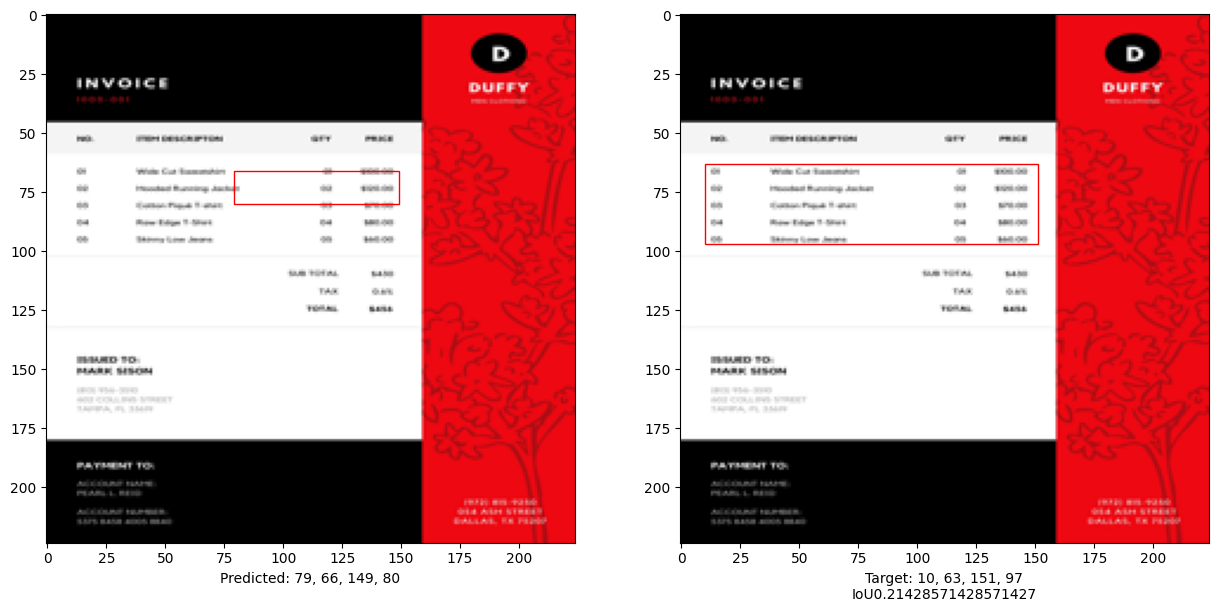

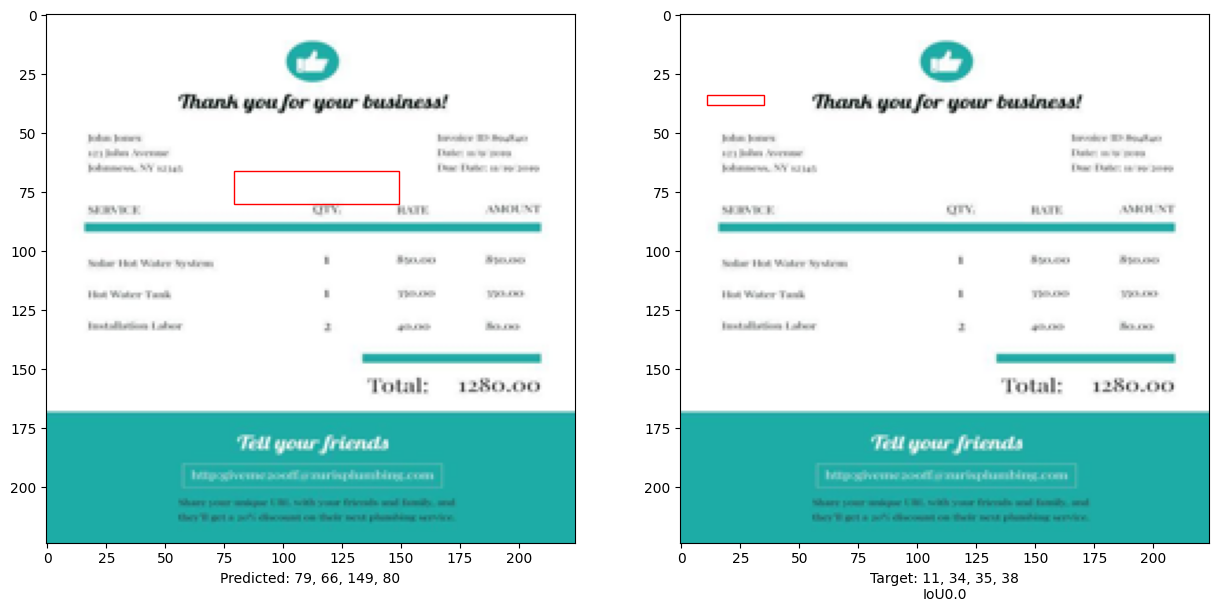

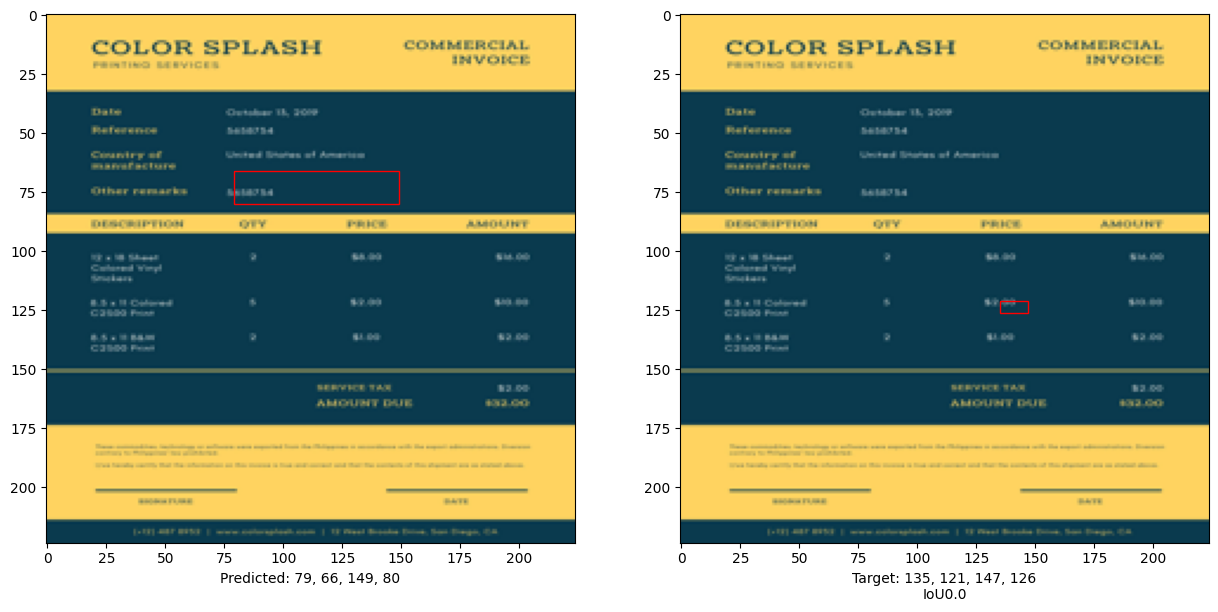

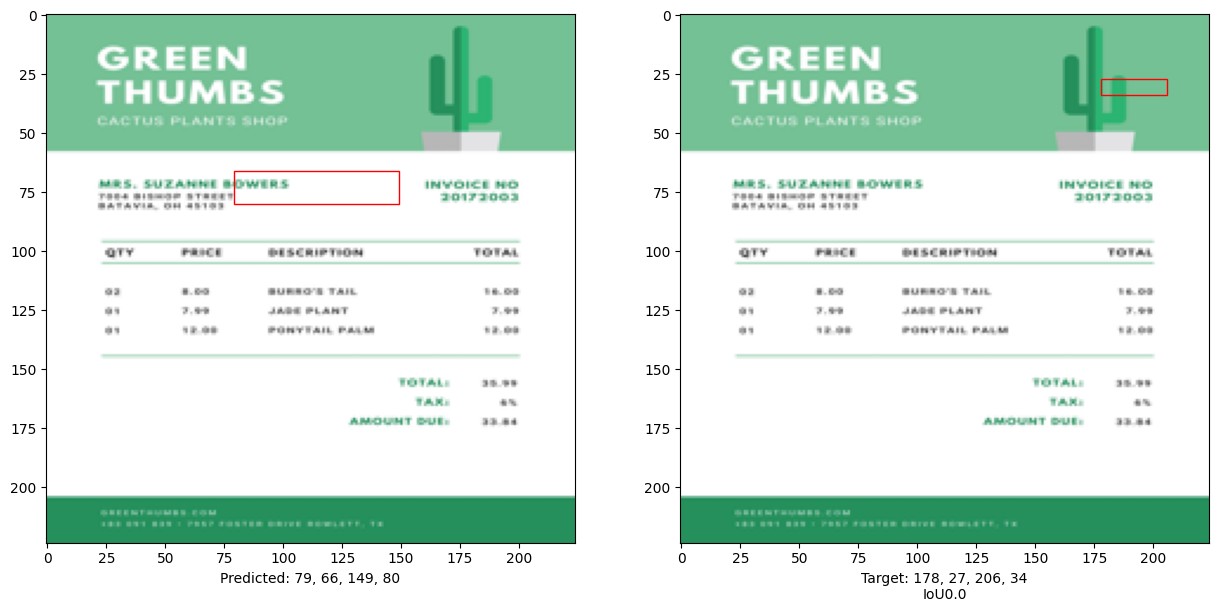

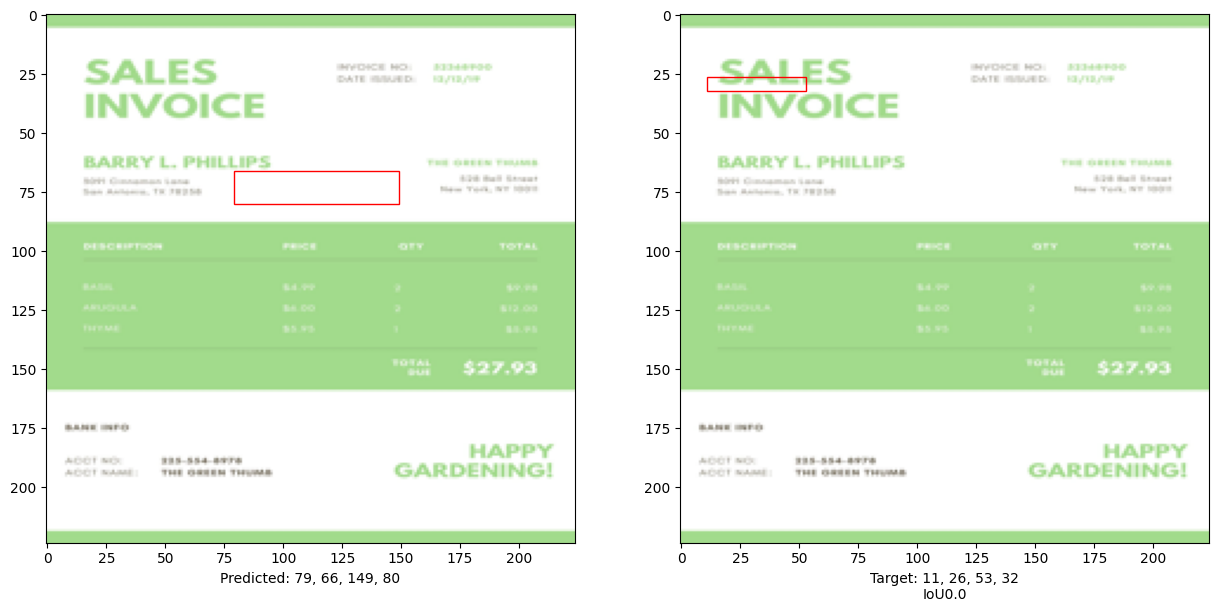

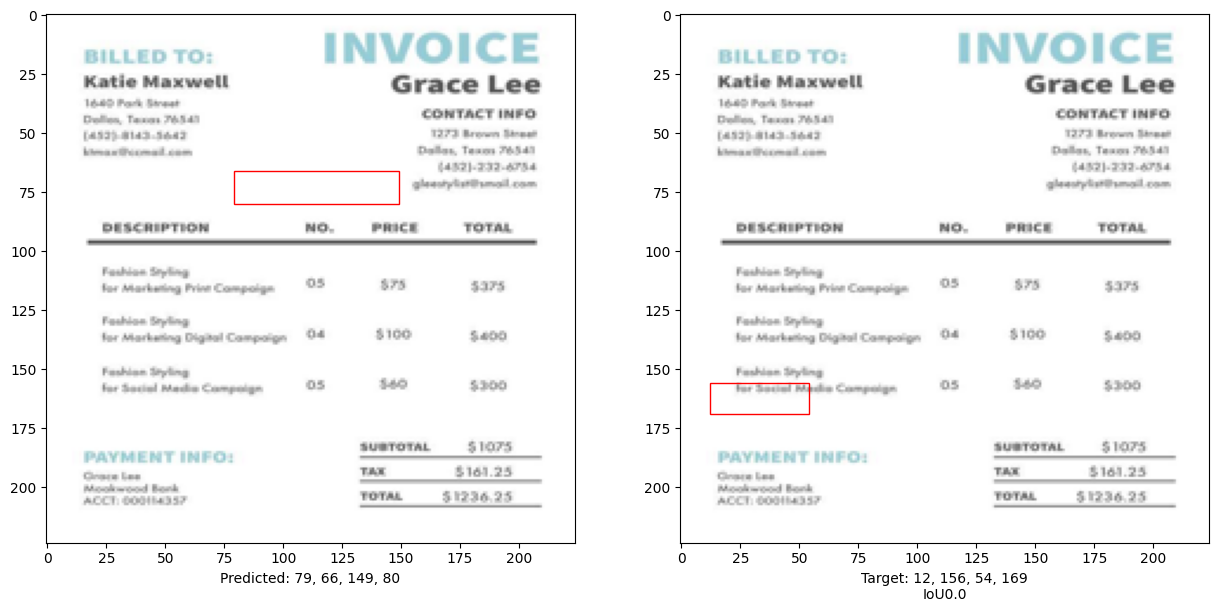

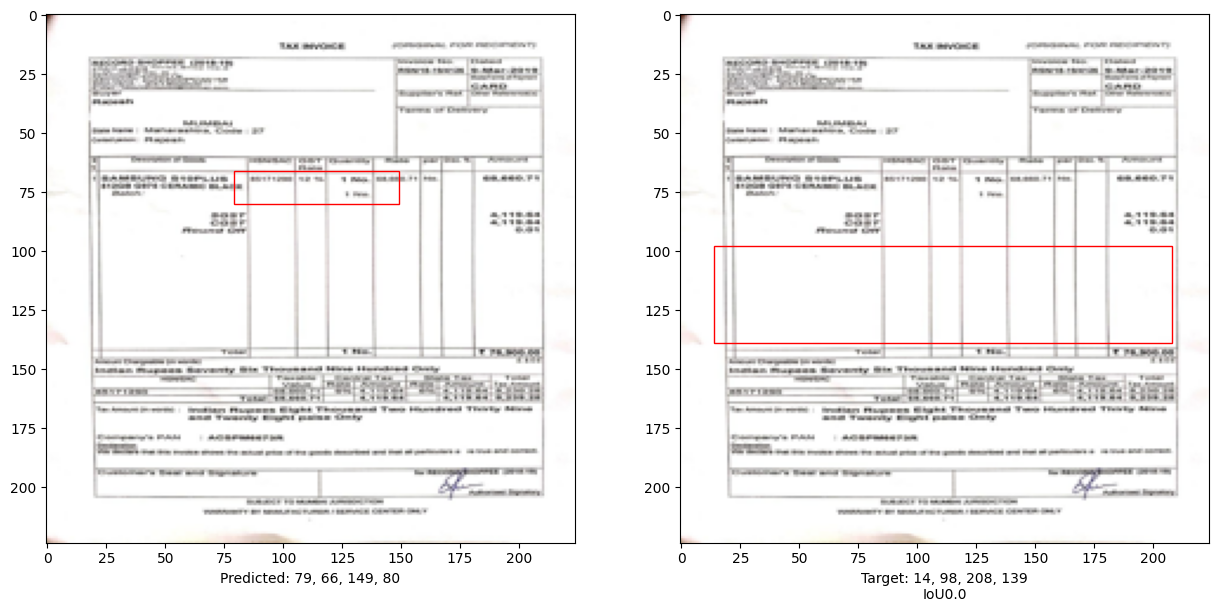

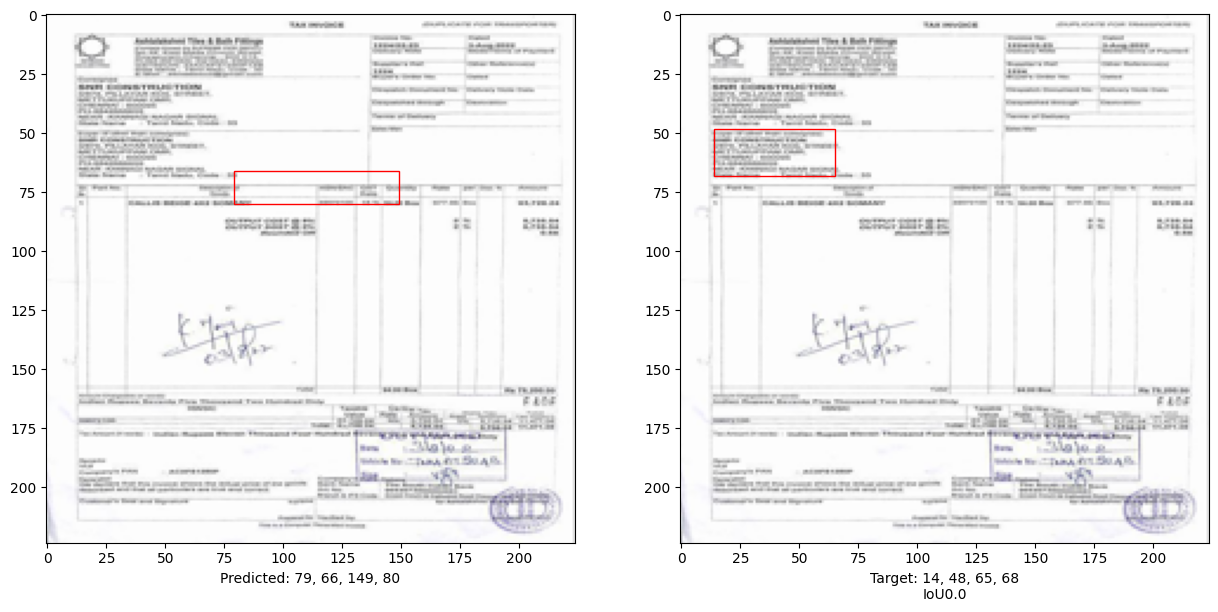

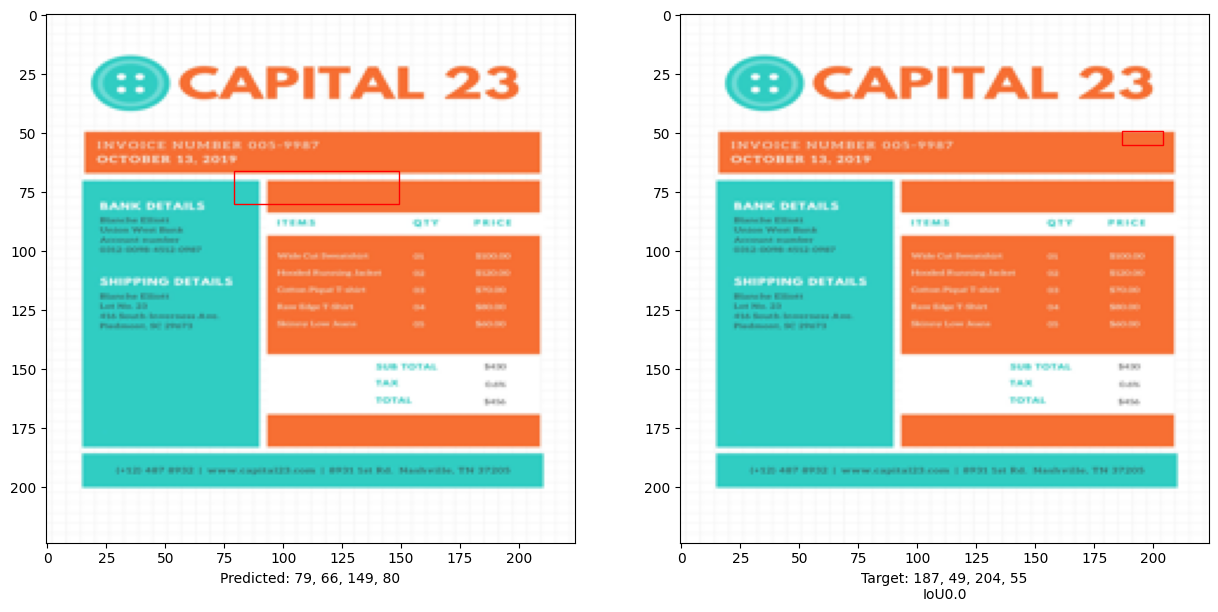

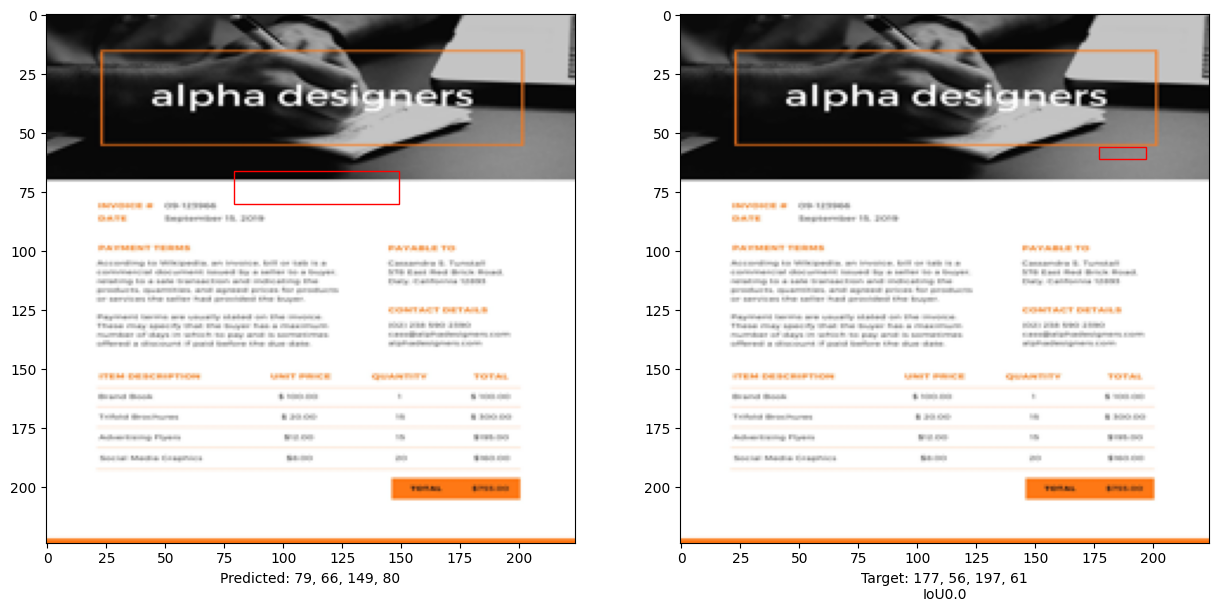

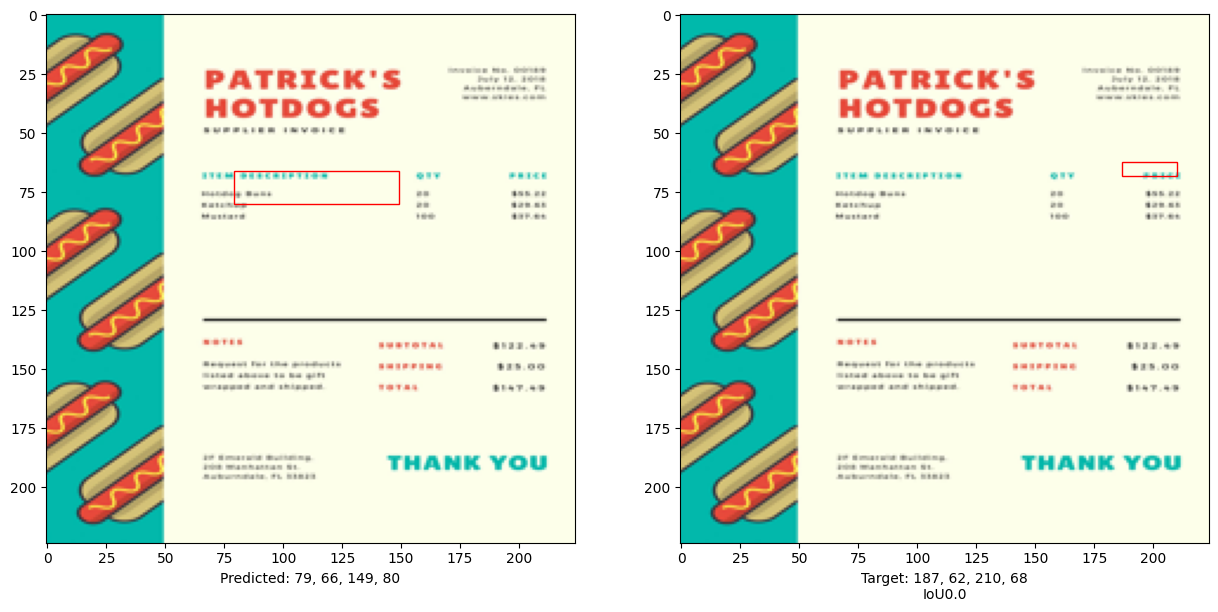

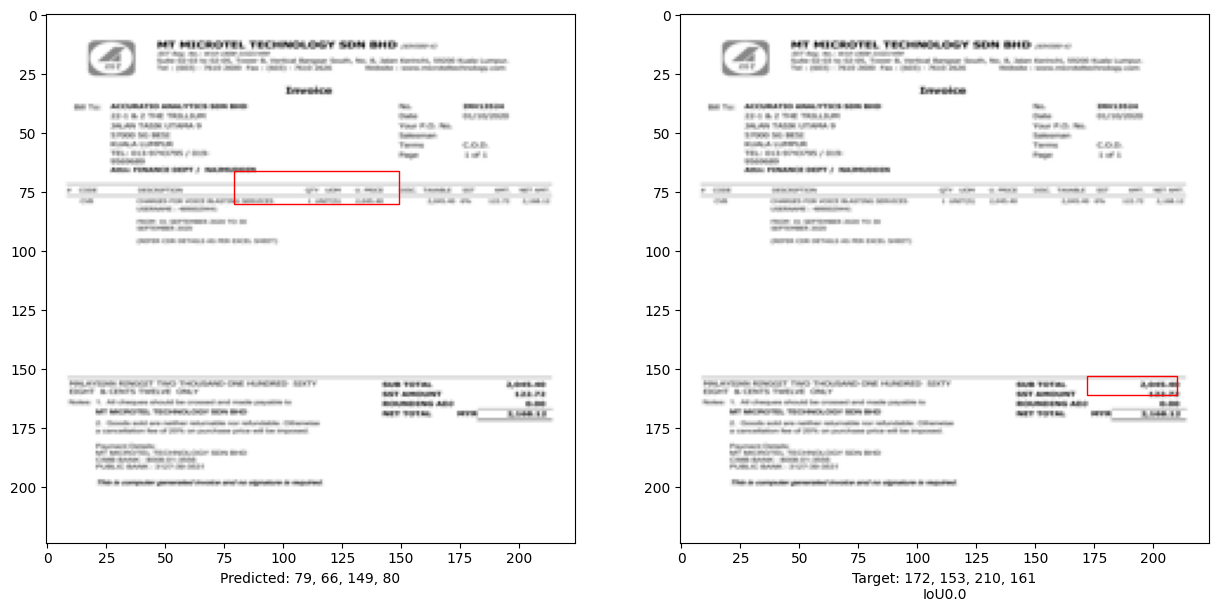

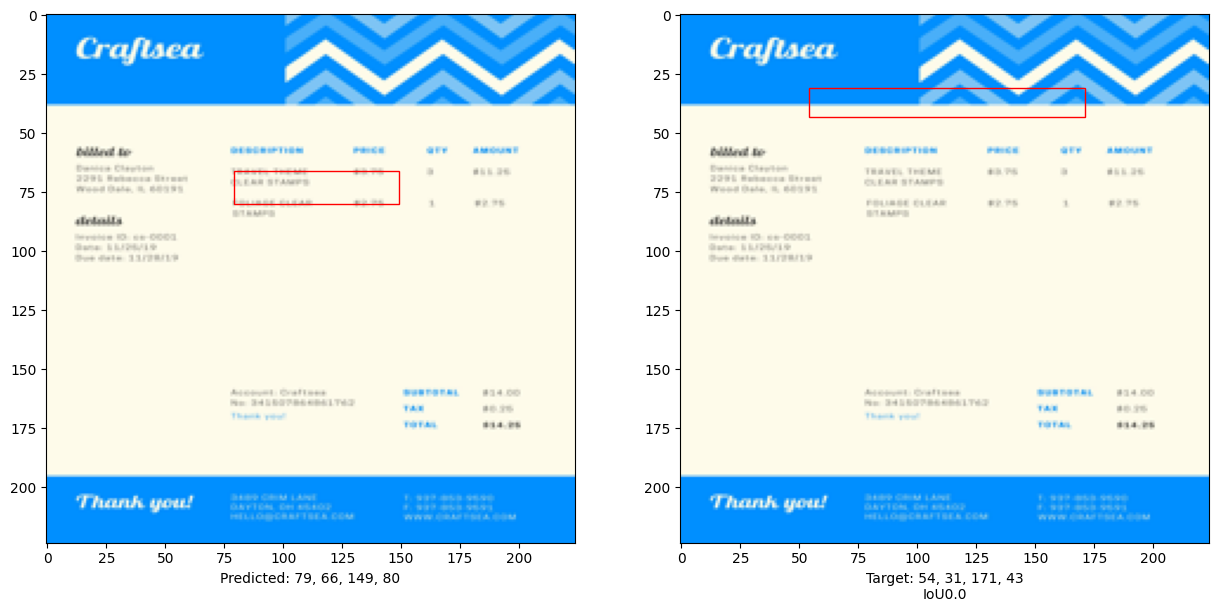

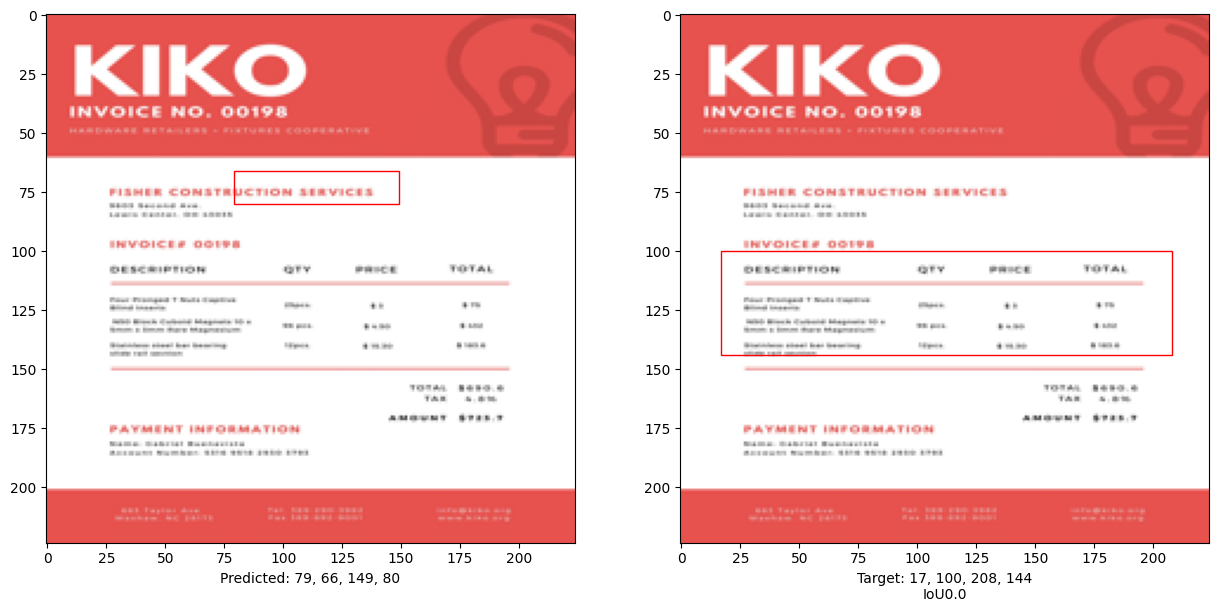

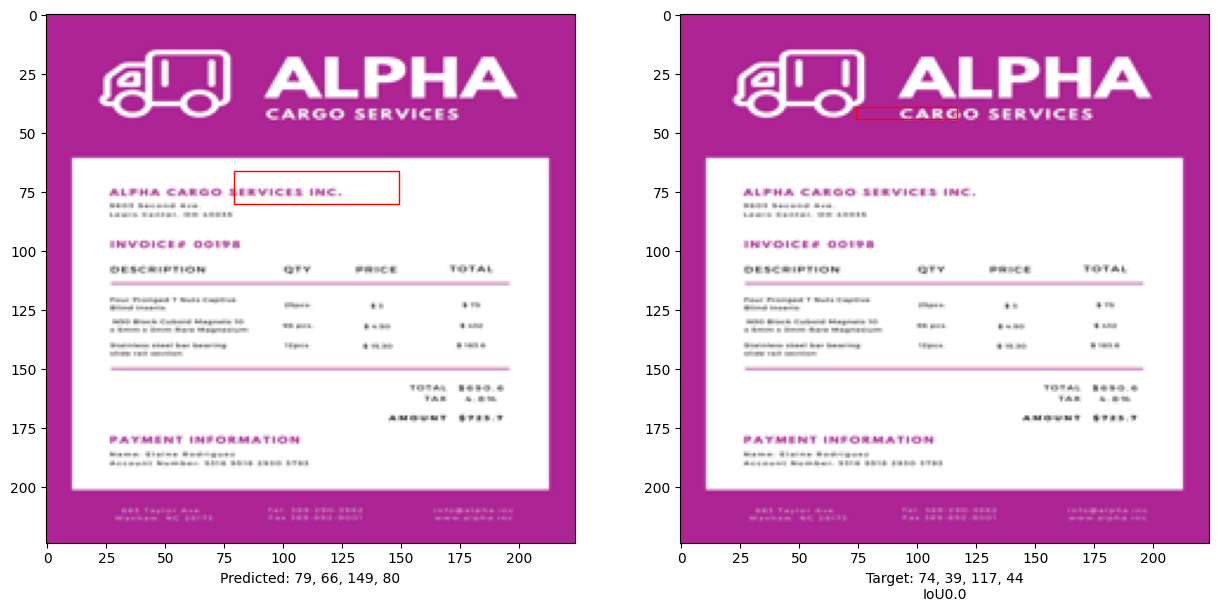

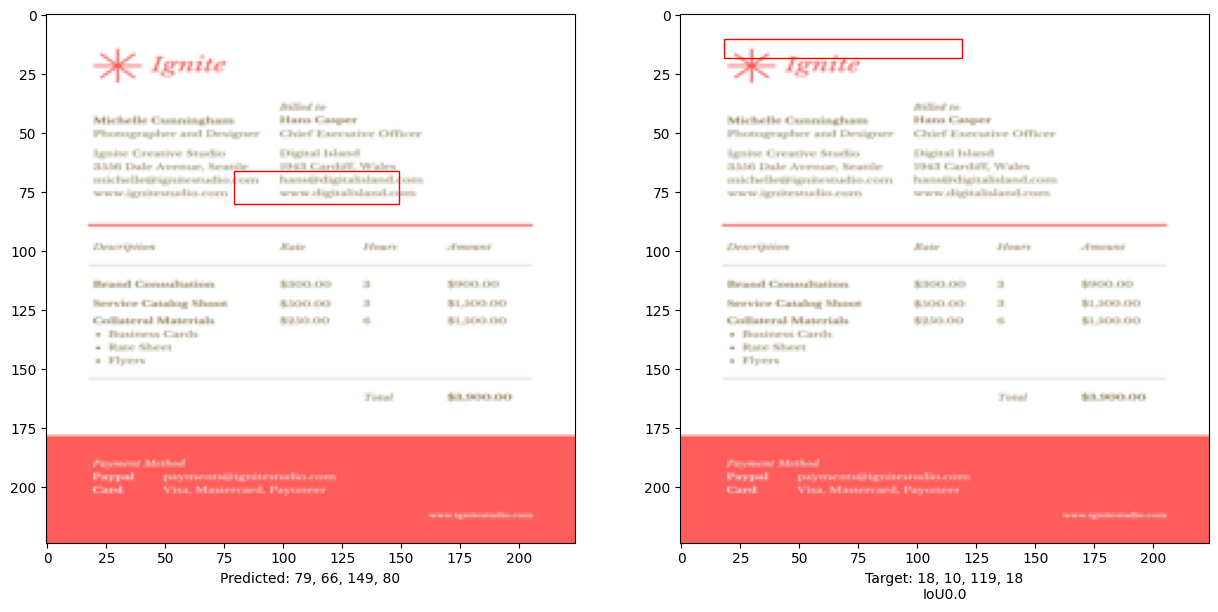

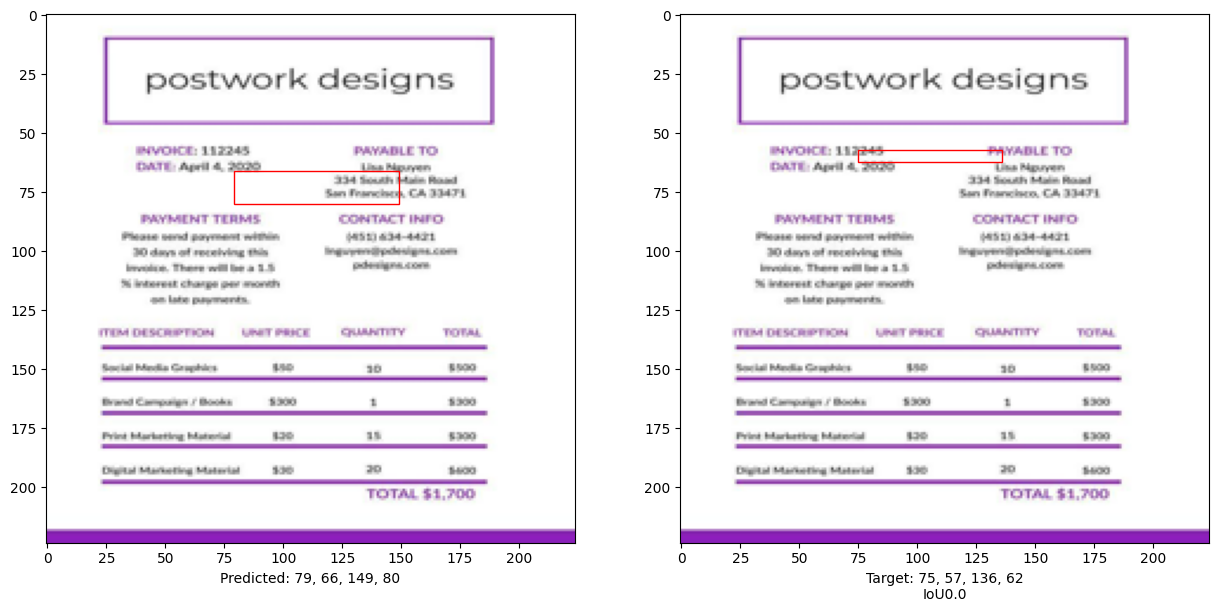

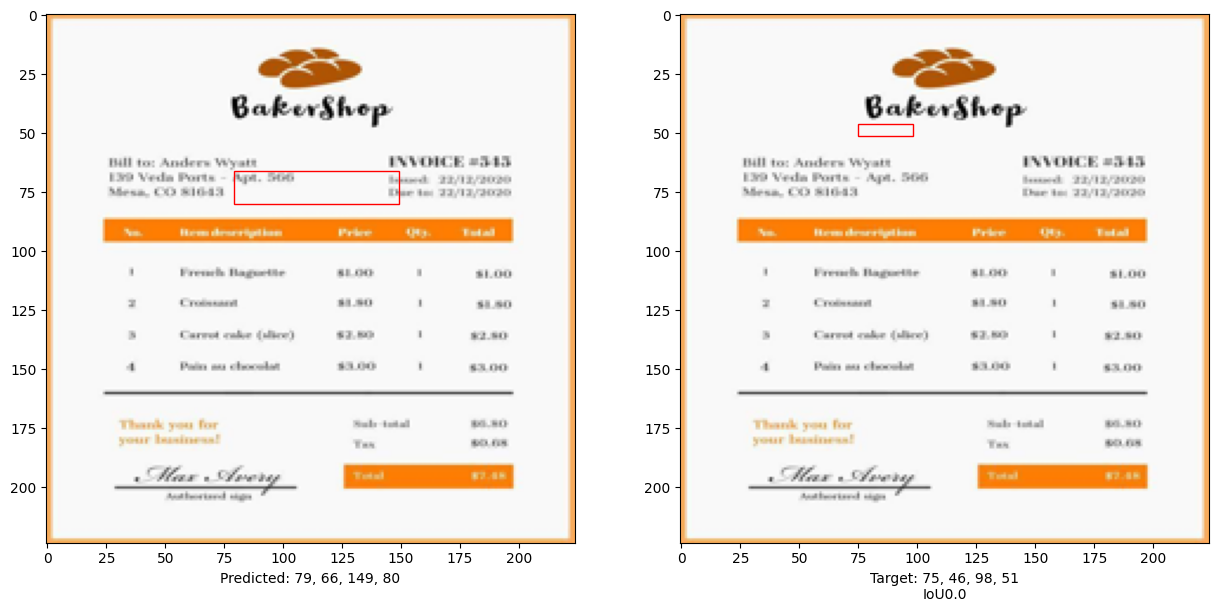

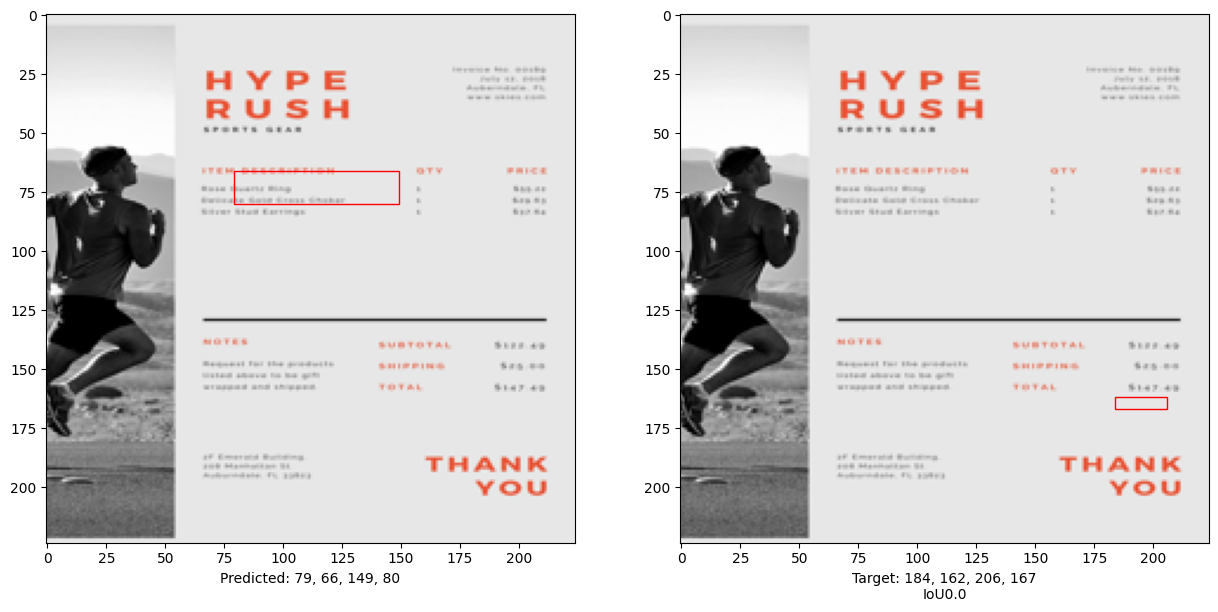

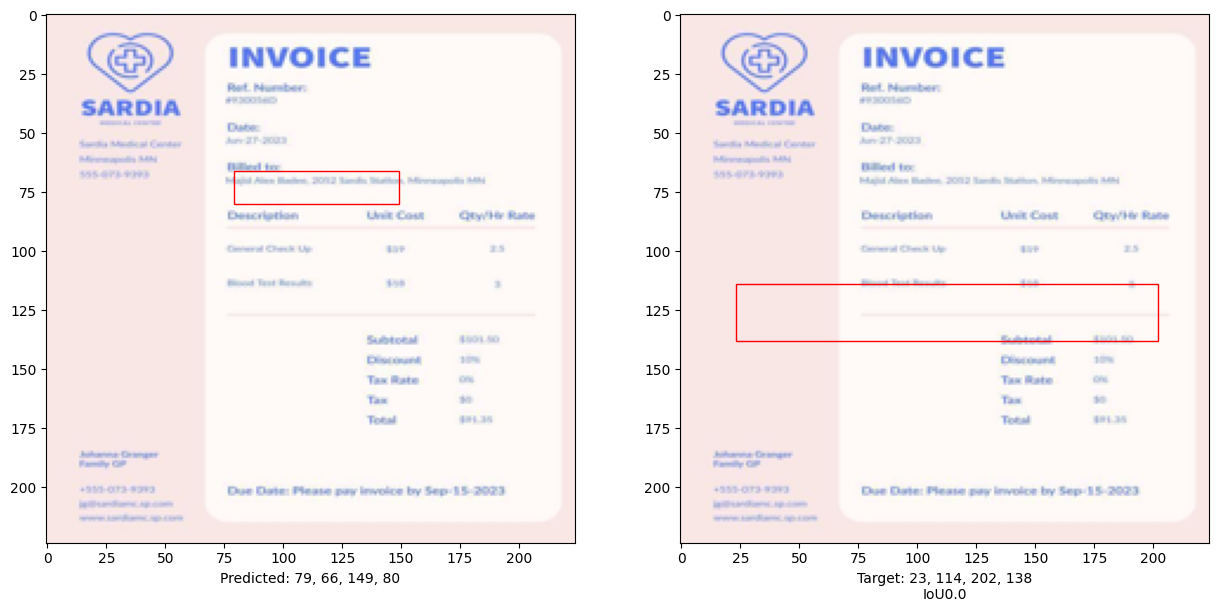

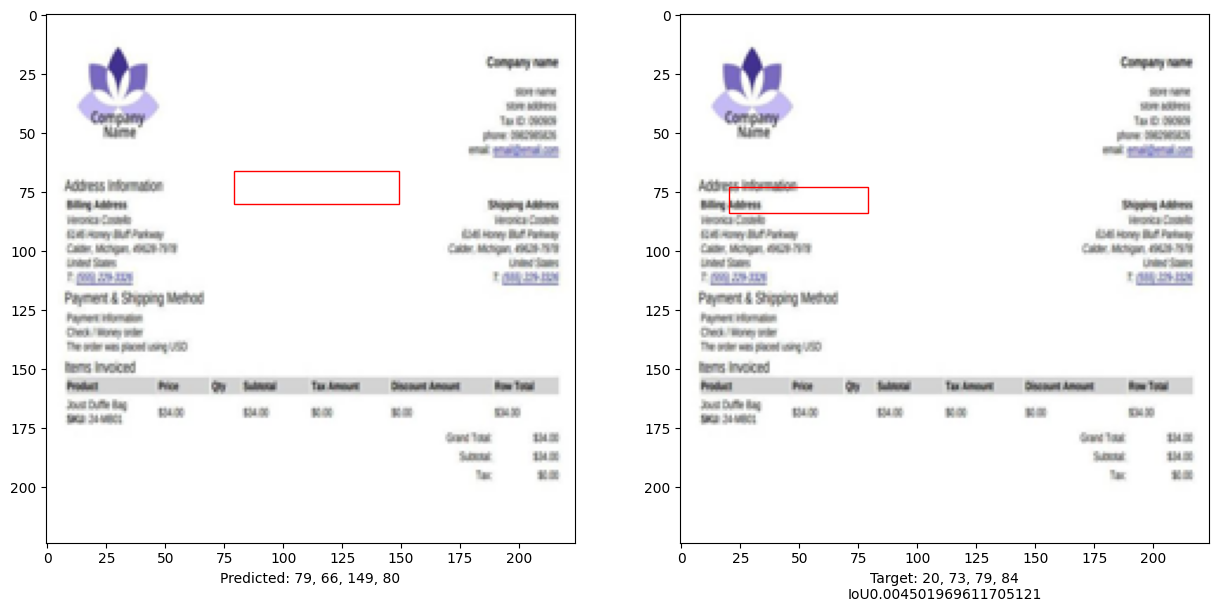

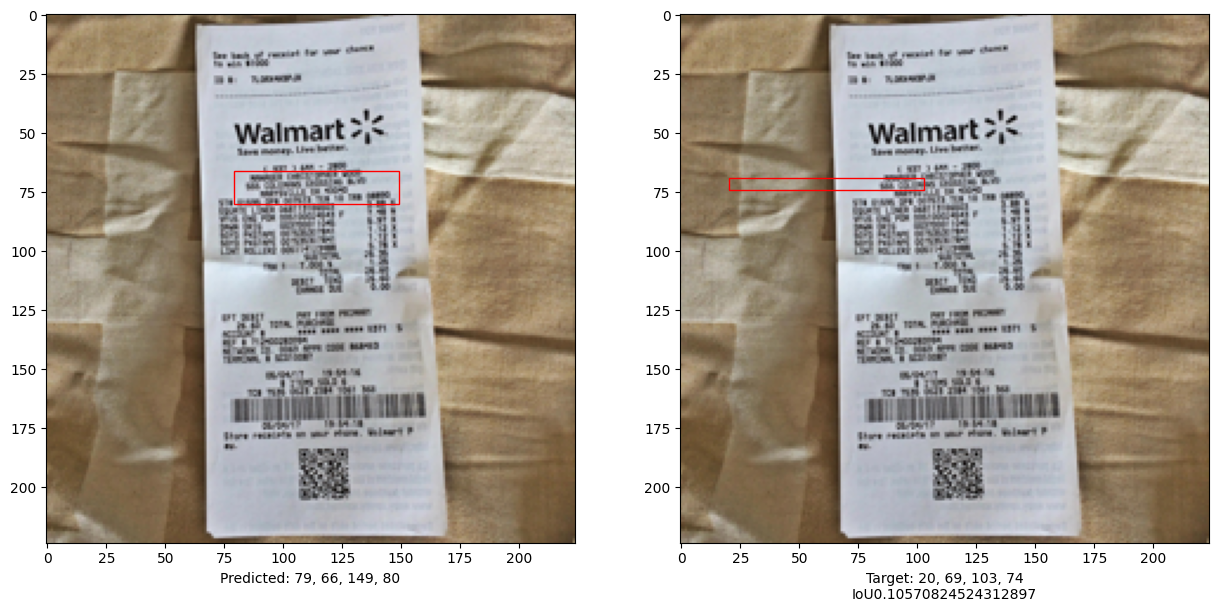

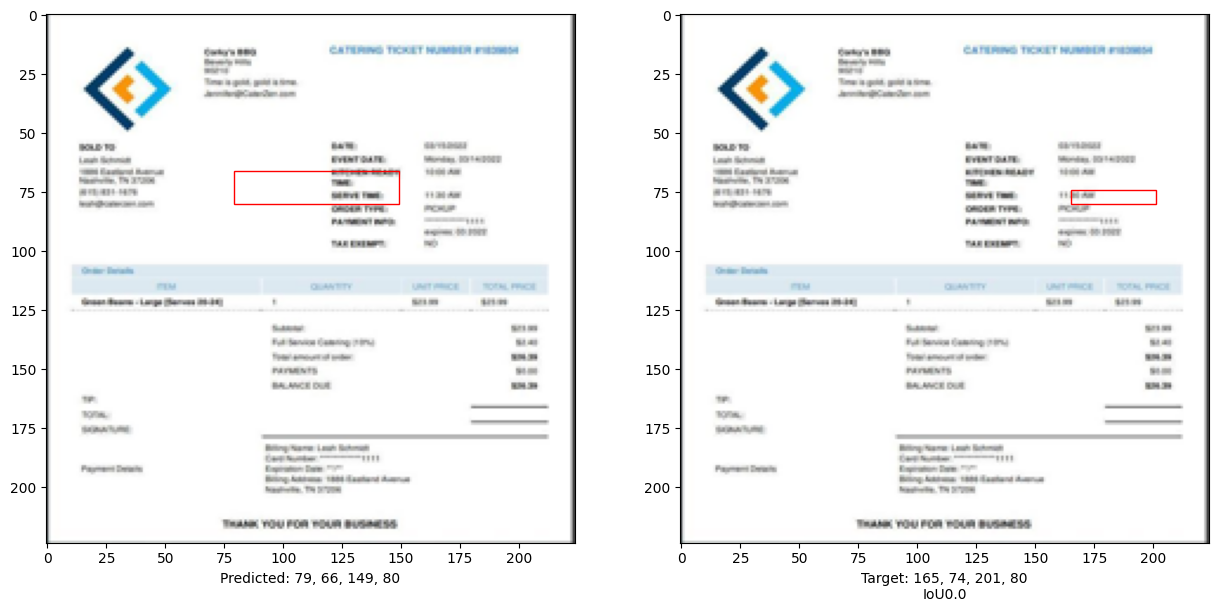

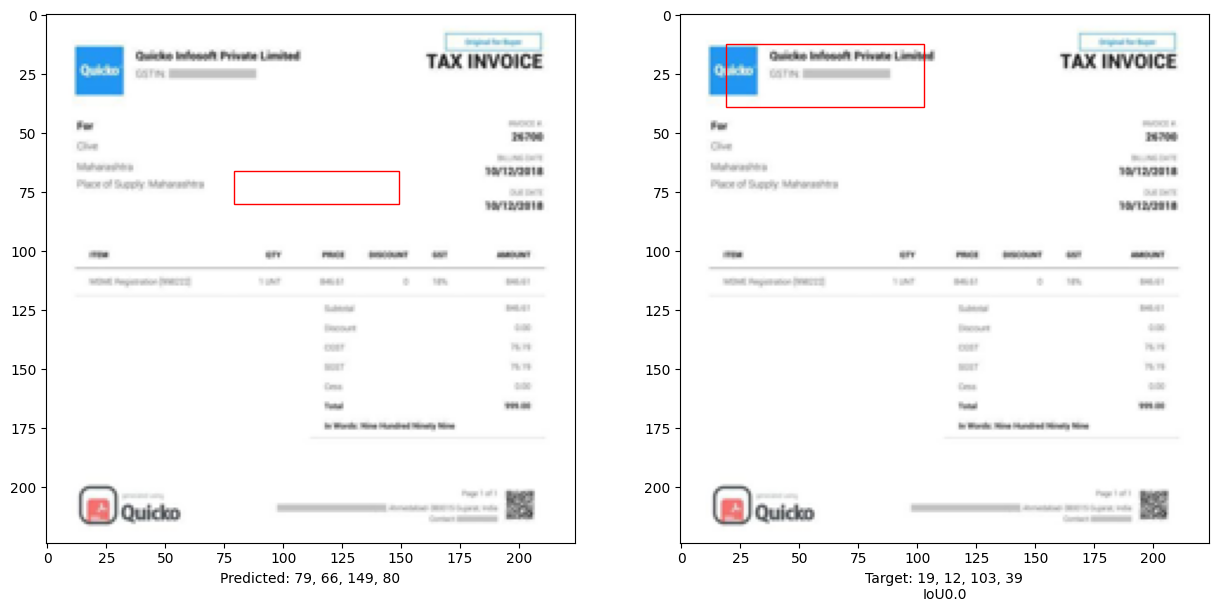

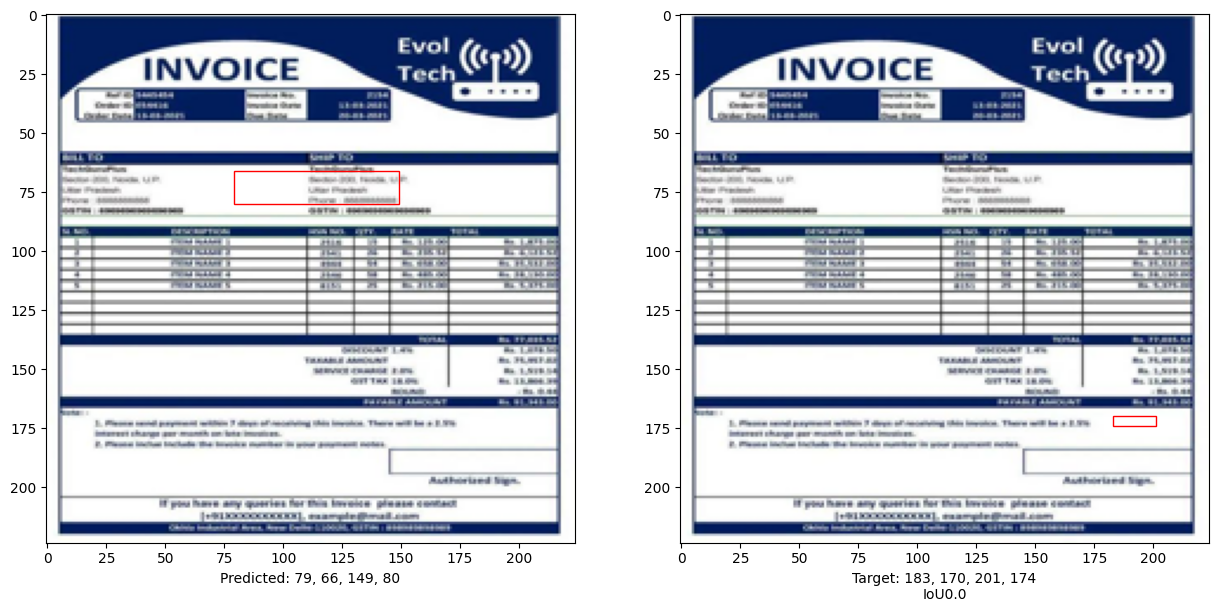

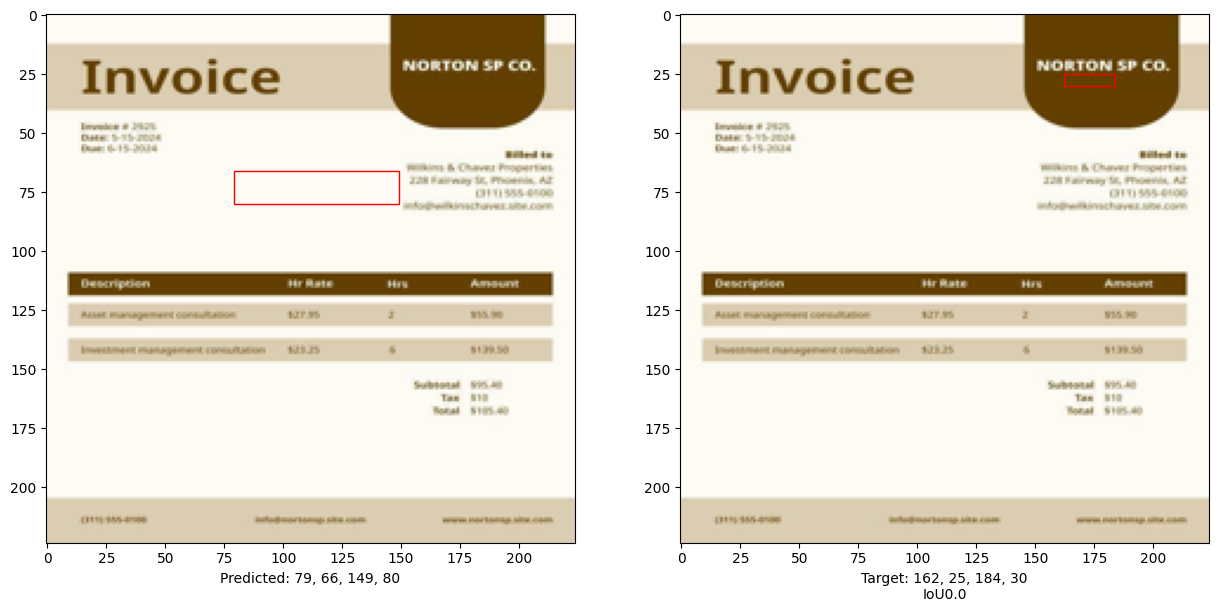

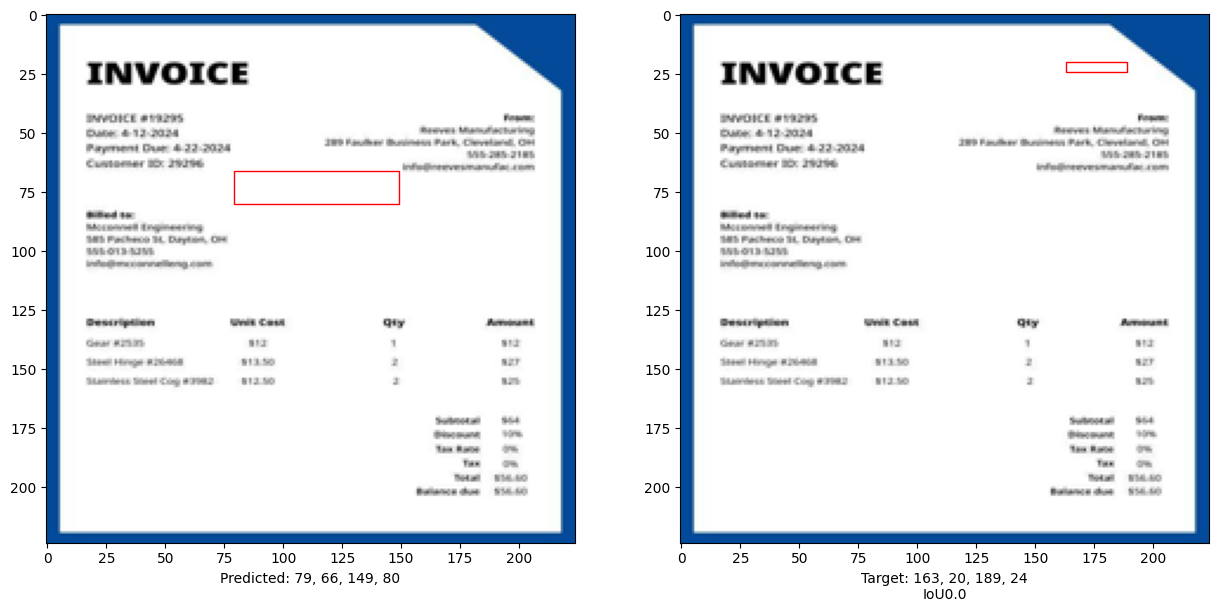

In [17]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.keras")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:30]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()